## Transporte de um pulso inicial de poluição numa situação em que o vento seja constante
 Alejandro Delgado Peralta


## Exercicio com aproximação de primeiro ordem, progressivo no tempo e regressivo no espaço.
Temos uma equação da adveção em 1D:

$$
\frac{\partial C}{\partial t} + U*\frac{\partial C}{\partial x} = 0,
$$

A condição inicial (CI) dada por uma gaussiana centrada em i=51, com decaimiento exponencial dado por `nr` (número de pontos) onde a amplitude da perturbação cai de um fator e:

$$
C(x,0) = C_{i,0} = C_0 \exp[\frac{-(i\Delta x - 51\Delta x)^2}{(nr*\Delta x)^2}]
$$

CFL:
$$
U*\frac{\Delta t}{\Delta x} < 1
$$

## Resultados

### Aproximação do ordem 1
Discretização e aproximação numérica, progressiva no tempo e regressiva no espaço:

$$
C^{n+1}_i = C^n_i - U*\frac{\Delta t}{\Delta x}(C^n_i - C^n_{i-1})
$$


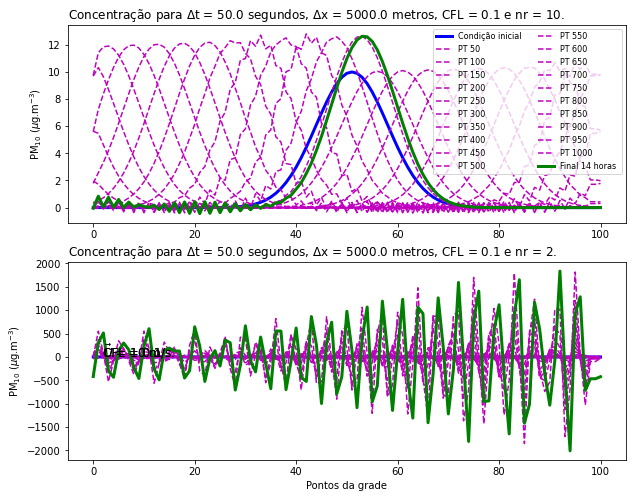

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from matplotlib import animation, rc
from functions import *

# Condições do exercício
# ----------------------
Nx      = 101           # pontos de grade
hora    = 14
tempo   = hora*3600     # segundos
dx      = 5000          # metros
dt      = 50            # segundos
Nt      = int(tempo/dt)
U       = 10            # m/s

x, dx   = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, dt   = np.linspace(0, tempo, Nt, retstep = True)

CFL     = U*dt/dx       # Courant number  CFL = 1, dt = 500
T, X    = np.meshgrid(t, x)

# Tipo de função, aproximação e contorno
# --------------------------------------
fun         =  "Gaussiana"          # Gaussiana, Retângulo
aprox       =  "matsuno"           # ordem1, ordem4, leapfrog, matsuno
cond_front  =  "periódica"          # fixa, periódica, radiacional
ylabel      =  "PM$_{10}$ ($\mu$g.m$^{-3}$)"
dP          =  50                  # Intervalo de passo de tempo

C_ref = sol_analytical(cond_front, fun, X, U, T, Nx)
c = {nr:sol_num(aprox, cond_front, fun, CFL, nr, Nx, Nt, x, dx, U, t) for nr in [10, 2]}
plot_sol_num(fun, aprox, cond_front, ylabel, dP, hora, Nx, Nt, CFL, U, x, dx, t, dt)

In [2]:
# Fazemos gifs
filenames = []
for n in range(0,int(Nt),dP):
    # plot the line chart
    fig, ax = plt.subplots(figsize=[8,6])
    ax.set_title(f"Hora: {(n*dt/3600).round(2)}, CFL = {CFL.round(2)}, " + r"$\Delta$t"+ f"= {dt.round(2)}")
    ax.plot(C_ref[10][:,n], color = "b", label="Sol. Analítica")
    ax.plot(C_ref[ 2][:,n], color = "b")
    ax.plot(c[10][:,n], color = 'r', linestyle = 'dashed', label= aprox+' nr: 10')
    ax.plot(c[ 2][:,n], color = 'm', linestyle = 'dashed', label= aprox+' nr: 2', alpha =.5)
    ax.set_ylim(0,15)
    ax.legend()
    ax.set_ylabel(ylabel)
    
    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)
    
    # save frame
    fig.savefig(filename, dpi=300)
    plt.close() # build gif
    
with imageio.get_writer('gifs/'+fun[:3]+'_' + aprox+'_'+ cond_front[:3] +'.gif', mode='I', duration = 1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [10]:
# Tipo de função, aproximação e contorno
# --------------------------------------
fun         =  "Retângulo"          # Gaussiana, Retângulo
aprox       =  "ordem1"           # ordem1, leapfrog
cond_front  =  "periódica"          # fixa, periódica, radiacional
ylabel      =  "PM$_{10}$ ($\mu$g.m$^{-3}$)"
dP          =  250                  # Intervalo de passo de tempo

In [5]:
C = np.array([0,1,2,3,4,5,6,7,8,9,10])

print(len(C), C[11-1], C[0], C[1:-1])

11 10 0 [1 2 3 4 5 6 7 8 9]


## Aproximação Leapfrog
Discretização no tempo e espaço das derivadas considerando diferenças centrais como segue:

$$
\frac{C^{n+1}_i - C^{n-1}_i}{2\Delta t} = -U*\frac{C^n_{i+1} - C^n_{i-1}}{2\Delta x}
$$

Se CFL é igual a $\gamma$, então temos

$$
C^{n+1}_i = C^{n-1}_i - \gamma(C^n_{i+1} - C^n_{i-1})
$$

para i = 0, consideramos usar o esquema de aproximação progressiva central no tempo:

$$
\frac{C^{n+1}_i - C^{n}_i}{\Delta t} = -U*\frac{C^n_{i+1} - C^n_{i-1}}{2\Delta x}
$$

Com isso temos

$$
C^{1}_i = C^{0}_i - \frac{\gamma}{2}(C^0_{i+1} - C^0_{i-1})
$$


In [9]:
# Condições do exercício
# ----------------------
Nx      = 101           # pontos de grade
hora    = 4
tempo   = hora*3600     # segundos
dx      = 5000          # metros
dt      = 10            # segundos
Nt      = int(tempo/dt)
U       = 10            # m/s

x, dx   = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, dt   = np.linspace(0, tempo, Nt, retstep = True)

CFL     = U*dt/dx       # Courant number
T, X    = np.meshgrid(t, x)

# Tipo de função, aproximação e contorno
# --------------------------------------
fun         =  "Gaussiana"          # Gaussiana, Retângulo
aprox       =  "leapfrog"           # ordem1, leapfrog
cond_front  =  "periódica"          # fixa, periódica, radiacional
ylabel      =  "PM$_{10}$ ($\mu$g.m$^{-3}$)"
dP          =  250                  # Intervalo de passo de tempo

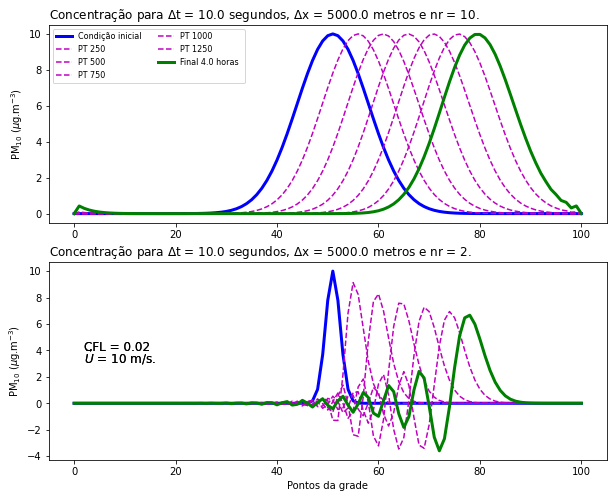

In [10]:
plot_sol_num(fun, aprox, cond_front, ylabel, dP)

In [11]:
# Condições do exercício
# ----------------------
Nx      = 101           # pontos de grade
hora    = 8
tempo   = hora*3600     # segundos
dx      = 5000          # metros
dt      = 10            # segundos
Nt      = int(tempo/dt)
U       = 10            # m/s

x, dx   = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, dt   = np.linspace(0, tempo, Nt, retstep = True)

CFL     = U*dt/dx       # Courant number
T, X    = np.meshgrid(t, x)

# Tipo de função, aproximação e contorno
# --------------------------------------
fun         =  "Gaussiana"          # Gaussiana, Retângulo
aprox       =  "leapfrog"           # ordem1, leapfrog
cond_front  =  "periódica"          # fixa, periódica, radiacional
ylabel      =  "PM$_{10}$ ($\mu$g.m$^{-3}$)"
dP          =  250                  # Intervalo de passo de tempo

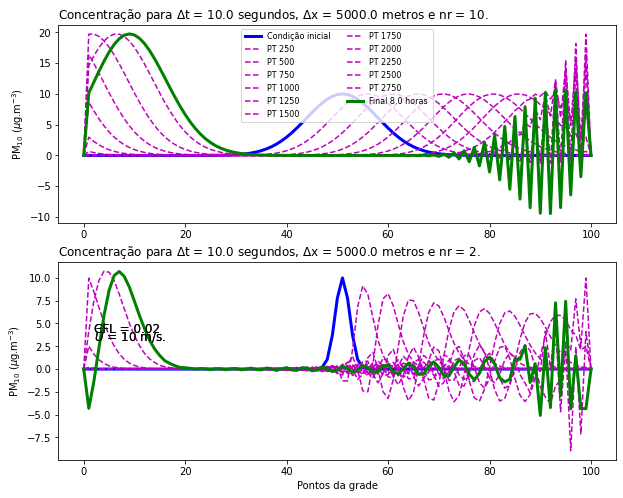

In [12]:
plot_sol_num(fun, aprox, cond_front, ylabel, dP)

# Muito obrigado